# Recurrent Neural Network Forecasting Model

In [1]:
import tseriesRoutines as routines
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import sqlite3
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from math import ceil, sqrt
from keras.models import Sequential
from keras import layers
from keras.optimizers import RMSprop, Adam, SGD, Adagrad, Adadelta

Using TensorFlow backend.


In [2]:
# RESULT REPRODUCIBILITY
########################
import tensorflow as tf
import random as rn

# The below is necessary in Python 3.2.3 onwards to
# have reproducible behavior for certain hash-based operations.
# See these references for further details:
# https://docs.python.org/3.4/using/cmdline.html#envvar-PYTHONHASHSEED
# https://github.com/keras-team/keras/issues/2280#issuecomment-306959926
import os
os.environ['PYTHONHASHSEED'] = '0'

# The below is necessary for starting Numpy generated random numbers
# in a well-defined initial state.
np.random.seed(42)

# The below is necessary for starting core Python generated random numbers
# in a well-defined state.
rn.seed(42)

# The below tf.set_random_seed() will make random number generation
# in the TensorFlow backend have a well-defined initial state.
# For further details, see: https://www.tensorflow.org/api_docs/python/tf/set_random_seed
tf.set_random_seed(42)

In [3]:
def genData(mongoid, conn, cursor, impute=True, freq='daily'):
    '''
    Generate a timeseries dataframe for timeseries modelling.
    mongoid: str. string of mongodb id.
    conn: sqlite3 connection.
    cursor: sqlite3 cursor.
    impute:
    freq:
    actualrevcount:
    '''
    initial = routines.sqlToDf(conn, cursor)
    allproduct = initial.selectReview3(mongoid, impute=impute)
    product = routines.tsSalesRateSentiment(allproduct, freq=freq)
    return product
    # product = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=True, 
    #   freq='daily')


In [4]:
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    # https://machinelearningmastery.com/multivariate-time-series-forecasting-lstms-keras/
    n_vars = 1 if type(data) is list else data.shape[1]
    df = data.copy()
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]

    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]

    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg = agg.dropna()
    return agg

In [5]:
def splitDataNN(df, n_in=1, n_out=1, scale=True, percent=0.2):
    '''
    df: pandas dataframe. 3 columns (sales, rating, ovsentiment) with date as index
    n_in:
    n_out:
    scale:
    percent:
    X_train, y_train, X_test, y_test, dftrain = splitDataNN(product, n_in=1, 
        n_out=1, scale=True, percent=0.2)
    '''
    dftrain = series_to_supervised(df, n_in=n_in, n_out=n_out)
    # specific to this case
    dftrain = dftrain.drop(dftrain.columns[[4, 5]], axis=1)
    values = dftrain.values

    if scale:
        scaler = MinMaxScaler()
        values = scaler.fit_transform(values)
    else:
        pass

    # training data
    X, y = values[:, :-1], values[:, -1]
    # train and test set
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=percent, 
            shuffle=False, random_state=42)
    # reshape input to be 3D [samples, timesteps, features]
    X_train = X_train.reshape((X_train.shape[0], 1, X_train.shape[1]))
    X_test = X_test.reshape((X_test.shape[0], 1, X_test.shape[1]))
    return X_train, y_train, X_test, y_test, dftrain, scaler

In [6]:
# computing the common-sense baseline MAE
def evaluate_naive_method(val_steps, val_gen):
    batch_maes = []
    for step in range(val_steps):
        samples, targets = next(val_gen)
        preds = samples[:, -1, 1]
        mae = np.mean(np.abs(preds-targets))
        batch_maes.append(mae)
    print(np.mean(batch_maes))

In [7]:
def flatModel(xtrain, ytrain, xtest, ytest, epochs, batch_size, units=50, shuffle=False, 
        metrics=['accuracy'], loss='mae', plot=True, lr=0.001):
    '''
    xtrain:
    ytrain:
    epochs:
    batch_size:
    units:
    shuffle:
    metrics:
    loss:
    plot:
    flatmodel = flatModel(X_train, y_train, epochs=80, batch_size=64)
    '''
    # 1 - densely connected model
    #############################
    model = Sequential()
    model.add(layers.Flatten(input_shape=(xtrain.shape[1], xtrain.shape[2])))
    model.add(layers.Dense(units, activation='relu'))
    model.add(layers.Dense(1))
    model.compile(optimizer=RMSprop(lr=lr), loss=loss, metrics=metrics)
    history = model.fit(xtrain, ytrain, 
                        epochs=epochs, batch_size=batch_size, 
#                        validation_split=0.2, 
                        validation_data=(xtest, ytest),
                        verbose=0, shuffle=False)
    # save the output
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(loss) + 1)

    # plot
    if plot:
        # loss plot
        plt.figure(1)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        # accuracy plot
        plt.figure(2)
        plt.plot(epochs, acc, label='Training acc')
        plt.plot(epochs, val_acc, label='Validation acc')
        plt.title('Training and validation Accuracy')
        plt.legend()
        plt.show()
    else:
        pass

    # print results
    print('loss: {0}'.format(np.mean(loss)))
    print('val_loss: {0}'.format(np.mean(val_loss)))
    print('acc: {0}'.format(np.mean(acc)))
    print('val_acc: {0}'.format(np.mean(val_acc)))

    # return model
    return history

def gruDropModel(xtrain, ytrain, xtest, ytest, epochs, batch_size, units, drop, recdrop, 
        shuffle=False, metrics=['accuracy'], loss='mae', plot=True, lr=0.001):
    '''
    xtrain:
    ytrain:
    epochs:
    batch_size:
    units:
    shuffle:
    metrics:
    loss:
    plot:
    grudropmodel = gruDropModel(X_train, y_train, epochs=1000, batch_size=64, units=256, 
        drop=0.2, recdrop=0.2)
    '''
    # 3 - GRU-based model with dropout
    ##################################
    model = Sequential()
    model.add(layers.GRU(units, 
        dropout=drop,
        recurrent_dropout=recdrop,
        input_shape=(xtrain.shape[1], xtrain.shape[2])))
    model.add(layers.Dense(1))
    model.compile(optimizer=RMSprop(lr=lr), loss=loss, metrics=metrics)
    history = model.fit(xtrain, ytrain, 
                        epochs=epochs, batch_size=batch_size, 
#                        validation_split=0.2,  
                        validation_data=(xtest, ytest),
                        verbose=0, shuffle=False)
    # save the output
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(loss) + 1)

    # plot
    if plot:
        # loss plot
        plt.figure(1)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        # accuracy plot
        plt.figure(2)
        plt.plot(epochs, acc, label='Training acc')
        plt.plot(epochs, val_acc, label='Validation acc')
        plt.title('Training and validation Accuracy')
        plt.legend()
        plt.show()
    else:
        pass

    # print results
    print('loss: {0}'.format(np.mean(loss)))
    print('val_loss: {0}'.format(np.mean(val_loss)))
    print('acc: {0}'.format(np.mean(acc)))
    print('val_acc: {0}'.format(np.mean(val_acc)))

    # return model
    return history

def lstmModel(xtrain, ytrain, xtest, ytest, epochs, batch_size, units, drop, recdrop, 
        shuffle=False, metrics=['accuracy'], loss='mae', plot=True, lr=0.001):
    '''
    xtrain:
    ytrain:
    epochs:
    batch_size:
    units:
    shuffle:
    metrics:
    loss:
    plot:
    lstmmodel = lstmModel(X_train, y_train, epochs=500, batch_size=64, units=256, 
        drop=0.2, recdrop=0.2)
    '''
    # 4 - LSTM-based model
    ######################
    model = Sequential()
    model.add(layers.LSTM(units, dropout=drop, recurrent_dropout=recdrop,
        input_shape=(xtrain.shape[1], xtrain.shape[2])))
    model.add(layers.Dense(1))
    model.compile(optimizer=RMSprop(lr=lr), loss=loss, metrics=metrics)
    history = model.fit(xtrain, ytrain, 
                        epochs=epochs, batch_size=batch_size, 
#                        validation_split=0.2, 
                        validation_data=(xtest, ytest),
                        verbose=0, shuffle=False)
    # save the output
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    epochs = range(1, len(loss) + 1)

    # plot
    if plot:
        # loss plot
        plt.figure(1)
        plt.plot(epochs, loss, label='Training loss')
        plt.plot(epochs, val_loss, label='Validation loss')
        plt.title('Training and validation loss')
        plt.legend()
        # accuracy plot
        plt.figure(2)
        plt.plot(epochs, acc, label='Training acc')
        plt.plot(epochs, val_acc, label='Validation acc')
        plt.title('Training and validation Accuracy')
        plt.legend()
        plt.show()
    else:
        pass

    # print results
    print('loss: {0}'.format(np.mean(loss)))
    print('val_loss: {0}'.format(np.mean(val_loss)))
    print('acc: {0}'.format(np.mean(acc)))
    print('val_acc: {0}'.format(np.mean(val_acc)))

    # return model
    return history

In [8]:
# make connection to sqlite db
conn = sqlite3.connect('product.db')
c = conn.cursor()

# enable foreign keys
c.execute("PRAGMA foreign_keys = ON")
conn.commit()

<br>pilihan:
>     2 data di database product.db dgn review > 900:
>         5aa2ad7735d6d34b0032a795
>         5aa39533ae1f941be7165ecd
>     cluster 3
>         5a93e8768cbad97881597597
>         or 
>         5a95d7ae35d6d33d3fea56ff
>     cluster 1
>         5aa2c35e35d6d34b0032a796
>     cluster 2 
>         5a92474635d6d32207bcd343
</br>

## <font color=blue> 1. Mongodb ID: 5aa2ad7735d6d34b0032a795 </font>

In [9]:
product = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=True, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

In [10]:
X_train.shape, product.shape

((382, 1, 3), (479, 3))

In [11]:
product.head()

,Sales,rating,ovsentiment
date,,,
2016-11-06,82,3.500000,0.500000
2016-11-07,88,5.000000,1.000000
2016-11-08,74,0.000000,0.000000
2016-11-09,72,0.000000,0.000000
2016-11-10,98,4.666667,0.333333


In [12]:
X_train

array([[[0.34693878, 0.7       , 0.5       ]],

       [[0.46938776, 1.        , 1.        ]],

       [[0.18367347, 0.        , 0.        ]],

       ...,

       [[0.67346939, 1.        , 0.33333333]],

       [[0.48979592, 0.        , 0.        ]],

       [[0.24489796, 1.        , 0.5       ]]])

In [13]:
dftrain.head()

,var1(t-1),var2(t-1),var3(t-1),var1(t)
date,,,,
2016-11-07,82.0,3.500000,0.500000,88
2016-11-08,88.0,5.000000,1.000000,74
2016-11-09,74.0,0.000000,0.000000,72
2016-11-10,72.0,0.000000,0.000000,98
2016-11-11,98.0,4.666667,0.333333,89


In [14]:
dftrain['var1(t-1)'].sum()

41466.0

### 1 - Densely Connected Model

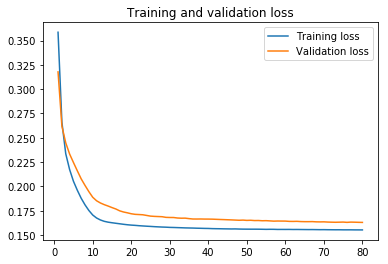

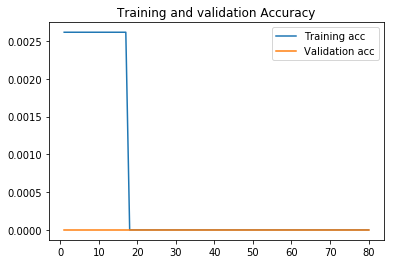

loss: 0.16518899811022178
val_loss: 0.1751114202896133
acc: 0.000556282722513089
val_acc: 0.0


In [15]:
flatmodel = flatModel(X_train, y_train, X_test, y_test, epochs=80, batch_size=8, loss='mae', units=4)

In [16]:
y_pred = flatmodel.model.predict(X_test)

In [17]:
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.20164971874266216

In [18]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.16301553697661073

In [19]:
flatmodel.model.save('./training/forecast_nn_5aa2ad7735d6d34b0032a795_flatmodel.h5')

### 3 - GRU-based Model with Dropout

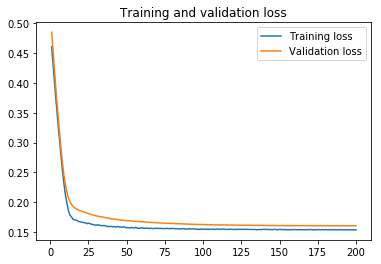

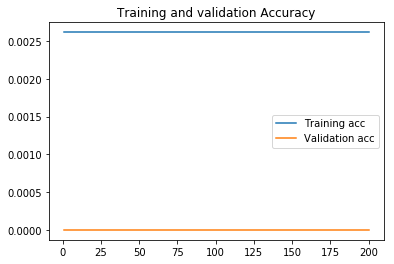

loss: 0.16513542991521624
val_loss: 0.17485637105070054
acc: 0.002617801047120419
val_acc: 0.0


In [20]:
grudropmodel = gruDropModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=8, units=8, drop=0.01, recdrop=0.01, lr=0.0001)

In [21]:
## y_pred = grudropmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.20164971874266216

In [22]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.16301553697661073

In [23]:
grudropmodel.model.save('./training/forecast_nn_5aa2ad7735d6d34b0032a795_grudropmodel.h5')

### 4 - LSTM-based Model

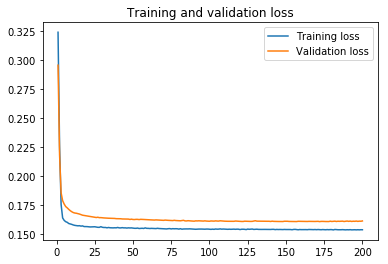

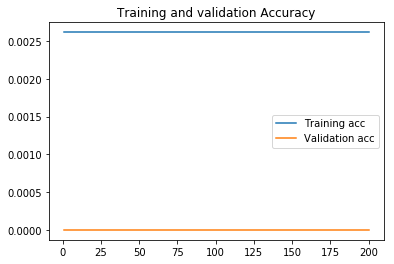

loss: 0.15576918431367548
val_loss: 0.16313578130366901
acc: 0.002617801047120419
val_acc: 0.0


In [24]:
lstmmodel = lstmModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=8, units=4, drop=0.002, recdrop=0.002)

In [25]:
y_pred = lstmmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.20010289222281888

In [26]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.1610152313777176

In [27]:
lstmmodel.model.save('./training/forecast_nn_5aa2ad7735d6d34b0032a795_lstmmodel.h5')

## <font color=blue> 2. Mongodb ID: 5aa39533ae1f941be7165ecd </font>

In [28]:
product = genData('5aa39533ae1f941be7165ecd', conn, c, impute=True, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

In [29]:
X_train.shape, product.shape

((462, 1, 3), (579, 3))

### 1 - Densely Connected Model

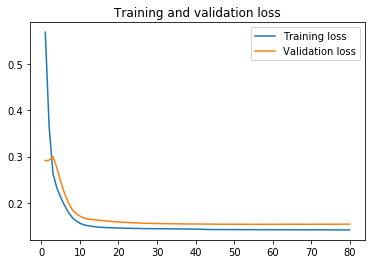

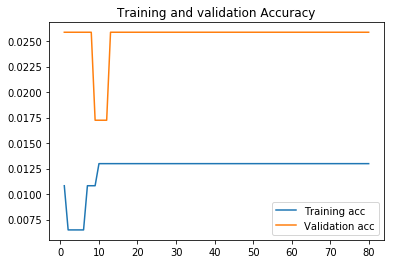

loss: 0.1566490310941746
val_loss: 0.16547012683004142
acc: 0.012472943813656958
val_acc: 0.02543103448275862


In [31]:
flatmodel = flatModel(X_train, y_train, X_test, y_test, epochs=80, batch_size=16, units=8)

In [32]:
y_pred = flatmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.19912837984102652

In [33]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.15378247606799972

In [34]:
flatmodel.model.save('./training/forecast_nn_5aa39533ae1f941be7165ecd_flatmodel.h5')

### 3 - GRU-based Model with Dropout

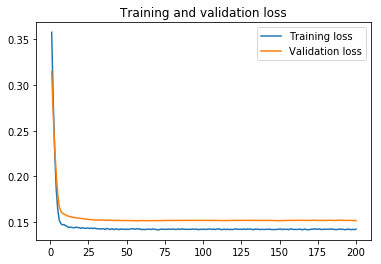

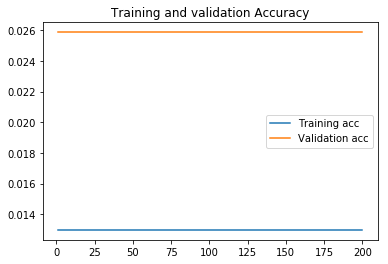

loss: 0.14514129108132479
val_loss: 0.15458750297540222
acc: 0.012987013083773778
val_acc: 0.025862069093975534


In [35]:
grudropmodel = gruDropModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=32, units=8, drop=0.01, recdrop=0.01, lr=0.0009)

In [36]:
y_pred = grudropmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.1958164488722456

In [37]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.15180171204024345

In [38]:
grudropmodel.model.save('./training/forecast_nn_5aa39533ae1f941be7165ecd_grudropmodel.h5')

### 4 - LSTM-based Model

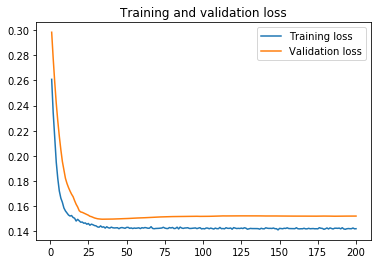

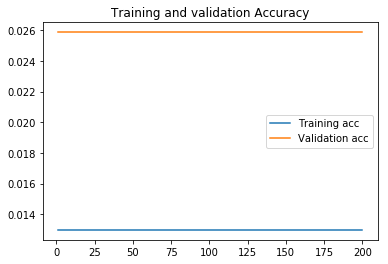

loss: 0.14549214484500678
val_loss: 0.15635208726186176
acc: 0.012987013083773778
val_acc: 0.025862069093975534


In [39]:
lstmmodel = lstmModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=32, units=8, drop=0.01, recdrop=0.01, lr=0.0005)

In [40]:
y_pred = lstmmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.19602011564147157

In [41]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.15220969558561437

In [42]:
lstmmodel.model.save('./training/forecast_nn_5aa39533ae1f941be7165ecd_lstmmodel.h5')

## <font color=blue> 3. Mongodb ID: 5a93e8768cbad97881597597 </font>

In [43]:
product = genData('5a93e8768cbad97881597597', conn, c, impute=True, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

In [44]:
X_train.shape, product.shape

((893, 1, 3), (1118, 3))

### 1 - Densely Connected Model

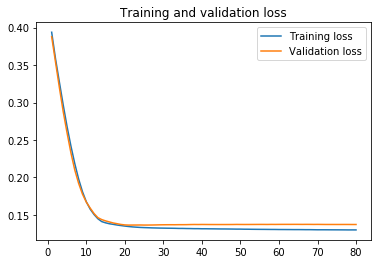

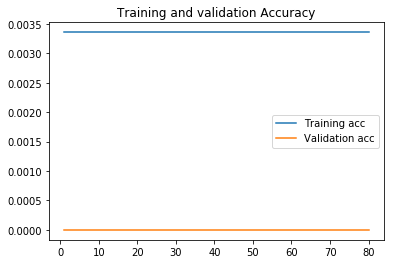

loss: 0.14931608516480963
val_loss: 0.15317736124353748
acc: 0.00335946248600224
val_acc: 0.0


In [45]:
flatmodel = flatModel(X_train, y_train, X_test, y_test, epochs=80, batch_size=64, loss='mae', units=8)

In [46]:
y_pred = flatmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.17175306056188655

In [47]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.13726255039171298

In [48]:
flatmodel.model.save('./training/forecast_nn_5a93e8768cbad97881597597_flatmodel.h5')

### 3 - GRU-based Model with Dropout

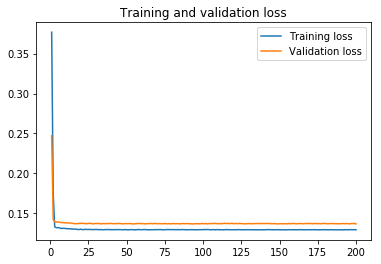

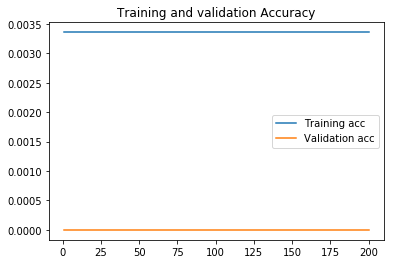

loss: 0.13110435283681313
val_loss: 0.1377615158685616
acc: 0.0033594624860022394
val_acc: 0.0


In [49]:
grudropmodel = gruDropModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=16, units=8, drop=0.01, recdrop=0.01, lr=0.0008)

In [50]:
y_pred = grudropmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.1715388494916003

In [51]:
mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.029425576884901904

In [52]:
grudropmodel.model.save('./training/forecast_nn_5a93e8768cbad97881597597_grudropmodel.h5')

### 4 - LSTM-based Model

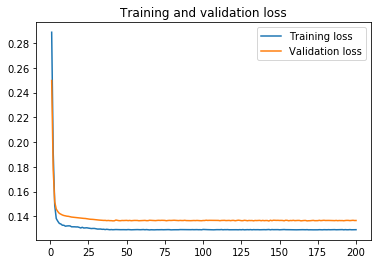

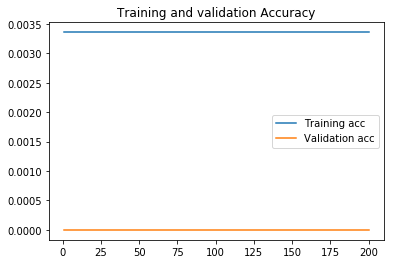

loss: 0.1307648488716509
val_loss: 0.1378474625173424
acc: 0.0033594624860022394
val_acc: 0.0


In [53]:
lstmmodel = lstmModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=16, units=8, drop=0.02, recdrop=0.02, lr=0.0008)

In [54]:
y_pred = lstmmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.17138677011044584

In [55]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.13661734309351567

In [56]:
lstmmodel.model.save('./training/forecast_nn_5a93e8768cbad97881597597_lstmmodel.h5')

## <font color=blue> 5. Mongodb ID: 5aa2c35e35d6d34b0032a796 </font>

In [77]:
product = genData('5aa2c35e35d6d34b0032a796', conn, c, impute=True, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

In [78]:
X_train.shape, product.shape

((340, 1, 3), (427, 3))

### 1 - Densely Connected Model

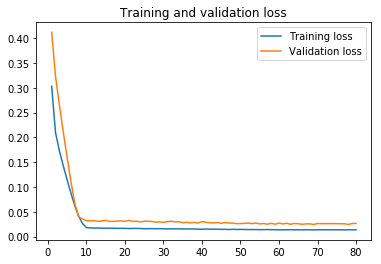

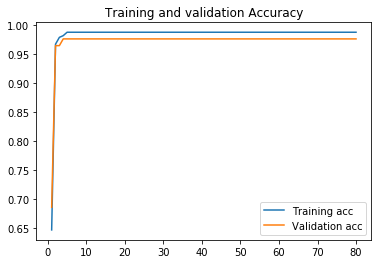

loss: 0.02788947971075472
val_loss: 0.04533125882958831
acc: 0.983529411764706
val_acc: 0.9728197674245335


In [83]:
flatmodel = flatModel(X_train, y_train, X_test, y_test, epochs=80, batch_size=16, loss='mae', units=8)

In [84]:
y_pred = flatmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.15314925486598618

In [85]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.026617906998496418

In [86]:
flatmodel.model.save('./training/forecast_nn_5aa2c35e35d6d34b0032a796_flatmodel.h5')

### 3 - GRU-based Model with Dropout

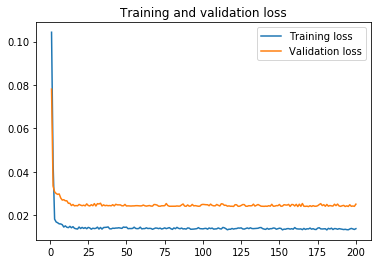

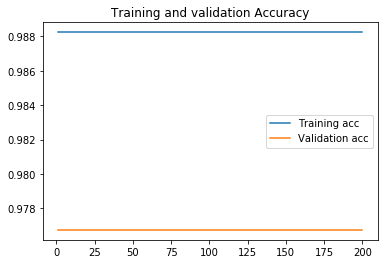

loss: 0.01453557742828065
val_loss: 0.02495594724714973
acc: 0.9882352941176471
val_acc: 0.9767441860465115


In [87]:
grudropmodel = gruDropModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=16, units=8, drop=0.01, recdrop=0.01, lr=0.0005)

In [88]:
y_pred = grudropmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.15282947002291475

In [89]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.025065263689950455

In [90]:
grudropmodel.model.save('./training/forecast_nn_5aa2c35e35d6d34b0032a796_grudropmodel.h5')

### 4 - LSTM-based Model

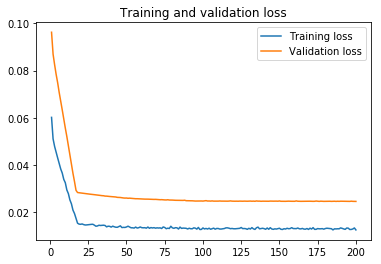

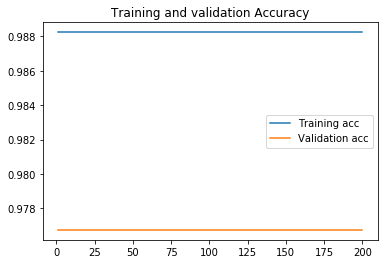

loss: 0.015090655331826009
val_loss: 0.028141025822747738
acc: 0.9882352941176471
val_acc: 0.9767441860465115


In [91]:
lstmmodel = lstmModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=8, units=4, drop=0.01, recdrop=0.01, lr=0.00008)

In [92]:
y_pred = lstmmodel.model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.15276060667776056

In [93]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.02450529865238296

In [94]:
lstmmodel.model.save('./training/forecast_nn_5aa2c35e35d6d34b0032a796_lstmmodel.h5')

## <font color=blue> 7. Mongodb ID: 5a9347b98cbad97074cb1890 </font>

In [52]:
product = genData('5a9347b98cbad97074cb1890', conn, c, impute=True, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

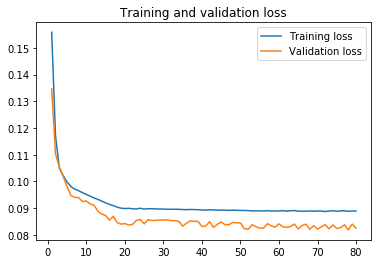

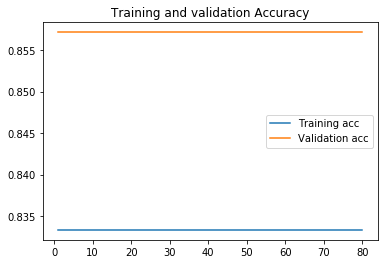

loss: 0.09169384667147247
val_loss: 0.08651060507233653
acc: 0.8333333323872278
val_acc: 0.8571428609272791


In [53]:
flatmodel = flatModel(X_train, y_train, X_test, y_test, epochs=80, batch_size=16, loss='mae', units=8)

In [54]:
y_pred = flatmodel.model.predict(X_train)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_train.reshape(-1,1)))

0.21686710054558597

In [55]:
mean_absolute_error(y_pred=y_pred, y_true=y_train.reshape(-1,1))

0.08838888519399223

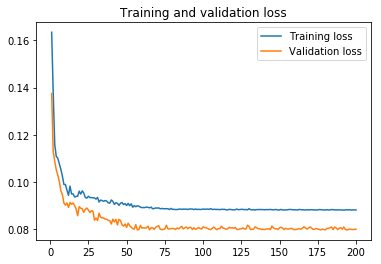

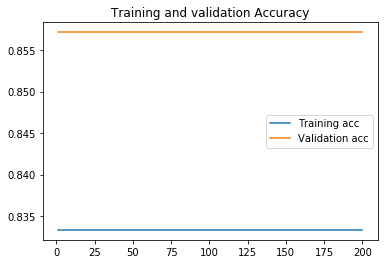

loss: 0.09063060857312401
val_loss: 0.08256976021237537
acc: 0.8333333333333335
val_acc: 0.857142858088963


In [56]:
grudropmodel = gruDropModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=8, units=4, drop=0.05, recdrop=0.05, lr=0.001)

In [57]:
y_pred = grudropmodel.model.predict(X_train)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_train.reshape(-1,1)))

0.21812007465223432

In [58]:
mean_absolute_error(y_pred=y_pred, y_true=y_train.reshape(-1,1))

0.08774278436173936

In [59]:
grudropmodel.model.save('./training/forecast_nn_5a9347b98cbad97074cb1890_grudropmodel.h5')

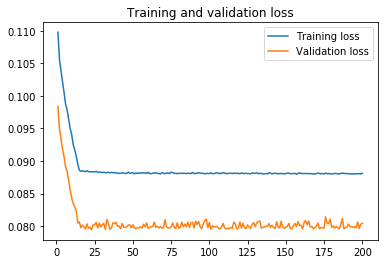

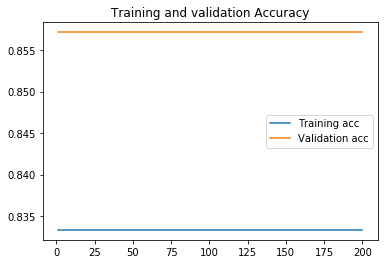

loss: 0.08879887875252092
val_loss: 0.0806149670096033
acc: 0.8333333333333335
val_acc: 0.857142858088963


In [60]:
lstmmodel = lstmModel(X_train, y_train, X_test, y_test, epochs=200, batch_size=8, units=4, drop=0.02, recdrop=0.02, lr=0.001)

In [61]:
y_pred = lstmmodel.model.predict(X_train)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_train.reshape(-1,1)))

0.2183707198510991

In [62]:
mean_absolute_error(y_pred=y_pred, y_true=y_train.reshape(-1,1))

0.08836139588882881

In [63]:
lstmmodel.model.save('./training/forecast_nn_5a9347b98cbad97074cb1890_lstmmodel.h5')

## performansi pada train set

In [9]:
from keras.models import load_model

In [10]:
product = genData('5aa2ad7735d6d34b0032a795', conn, c, impute=True, freq='daily')
X_train, y_train, X_test, y_test, dftrain, scaler = splitDataNN(product, percent=0.2)

In [11]:
model = load_model('./training/forecast_nn_5aa2ad7735d6d34b0032a795_flatmodel.h5')

In [12]:
y_pred = model.predict(X_test)
np.sqrt(mean_squared_error(y_pred=y_pred, y_true=y_test.reshape(-1,1)))

0.20164971874266216

In [13]:
mean_absolute_error(y_pred=y_pred, y_true=y_test.reshape(-1,1))

0.16301553697661073